# Interactias Geo Selected Network

One way of examining the impact of invasive species is to look at all their interactions and the interations those organisms have with each other. This full interaction network gives you an idication of whether a species might be a "keystone" species and therefore have a disproportionatly large impact.

In this step of the evolution of this script it will be adapted to quantify species by their occupancy.

I will harvest species interactions data from GLOBI (https://www.globalbioticinteractions.org/) to discover the species that interact with an invasive species.
I will then harvest all the interactions for those species to create two tiers of interactions.
I will then count all the occurences of these in species in the Belgian datacube.
I will then create a network diagram to visualize this.

This notebook takes considerable insperation and code from Yikang Li's project on GLoBI (https://curiositydata.org/part1_globi_access/).

In [151]:
import sys
print(sys.version)

#Python 3.7.4 (default, Aug 9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
#pygbif 0.3.0

3.7.3 (default, Mar 27 2019, 17:13:21) [MSC v.1915 64 bit (AMD64)]


In [152]:
import pandas as pd
import re
import matplotlib.pyplot as plt
from pygbif import species
from pygbif import occurrences as occ
import sqlite3
from sqlite3 import Error

### Setting up some parameters

In [153]:
# There is no point accepting all the species that have more than one record.
# There are too many casual records of plants and biirds
thresholdForOccNum = 5
# If you want to exclude the interactions list them comma seperated here
interactionsToExclude = "interactsWith"

In [154]:

## Define the country of interest
country  = 'BE'

## Define the year from where to consider records for the occupancy
year = 2000

## Define the place to find the data cube for occupancy data
## Currently the cube contains only Belgian data so that is all that can be used
database = r"..\data\cube.db" 
globiDB = r"..\data\globi.db"

### Define the key taxon for the notebook for which to find all interactions


In [155]:
#taxon = "Oxalis corniculata"
#taxon = "Oxalis pes-caprae"
#taxon = "Abramis brama"
#taxon = "Dikerogammarus villosus" # killer shrimp
#taxon = "Lantanophaga pusillidactyla"
#taxon = "Lantana camara"
#taxon = "Cirsium vulgare"
#taxon = "Solenopsis invicta"
#taxon = "Linepithema humile" #Argentine ant
taxon = "Procyon lotor" # raccoon
#taxon = "Carpobrotus edulis"
#taxon = "not exist"
#taxon = "Sciurus carolinensis" # Eastern grey squirrel

#taxon = "Triturus carnifex"
#taxon = "Xenopus laevis"
#taxon = "Rhinella marina"
#taxon = "Cynops pyrrhogaster"
#taxon = "Pachytriton labiatus"
#taxon = "Pleurodeles waltl"
#taxon = "Podarcis sicula"


## Check to see if the taxon exits in GBIF

In [156]:
try:
    #NOTE: The function method name_suggest has a different behavior with regards to the gender of Latin names to name_backbone
    # If name_backbone is given a name in one gender it can still return the best match from the GBIF backbone if that
    # name is spelled as if it was another gender.
    #key = species.name_suggest(q=taxon, limit = 1)
    match = species.name_backbone(name=taxon, limit = 1)
    #print(key)
    
    # if there is no match this is returned form .name_backbone {'confidence': 100, 'matchType': 'NONE', 'synonym': False}
    if match['matchType'] == 'NONE':
        raise ValueError("TAXON NOT FOUND ON GBIF!")
    else:
        key = match['usageKey']
except ValueError as ve:
    print(ve)
    exit(1)




In [157]:

print('The taxon to be studied is ' + match['scientificName'])

The taxon to be studied is Procyon lotor (Linnaeus, 1758)


### Take a look at the interactions that the taxon has

In [158]:
# What are all the types of interactions involving taxon as source taxon?
#data[data['sourceTaxonName'] == taxon]['interactionTypeName'].unique()
try:
    connGlobi = sqlite3.connect(globiDB)
except Error as e:
    print(e)

In [159]:
curGlobi = connGlobi.cursor()
curGlobi.execute("SELECT interactionTypeName from globi  WHERE sourceTaxonName = ? GROUP BY interactionTypeName;", (taxon,))
interactDataTaxon = curGlobi.fetchall()

In [160]:
interactDataTaxon

[('eats',), ('interactsWith',), ('preysOn',)]

In [161]:
curGlobi = connGlobi.cursor()
curGlobi.execute("SELECT interactionTypeName from globi  WHERE targetTaxonName = ? GROUP BY interactionTypeName;", (taxon,))
interactDataTaxon = curGlobi.fetchall()
interactDataTaxon

[('eats',),
 ('ectoParasiteOf',),
 ('endoparasiteOf',),
 ('hasHost',),
 ('interactsWith',),
 ('parasiteOf',),
 ('pathogenOf',),
 ('preysOn',)]

## Get the primary interation data for the species in question

In [164]:
curGlobi = connGlobi.cursor()
curGlobi.execute("SELECT * from globi  WHERE targetTaxonName = ? and interactionTypeName NOT IN (?);", \
                 (taxon,interactionsToExclude,))
interactDataTaxon = curGlobi.fetchall()

In [165]:
curGlobi = connGlobi.cursor()
curGlobi.execute("SELECT * from globi  WHERE sourceTaxonName = ? and interactionTypeName NOT IN (?);", \
                 (taxon,interactionsToExclude,))
sources = curGlobi.fetchall()

In [166]:
interactDataTaxon.extend(sources)
len(interactDataTaxon)

2558

In [167]:
# Convert to a Pandas dataframe
interactDataTaxon = pd.DataFrame(interactDataTaxon)

In [168]:
# Add column names
interactDataTaxon
interactDataTaxon.columns = ['sourceTaxonId', \
                                'sourceTaxonIds','sourceTaxonName','sourceTaxonRank','sourceTaxonPathNames', \
                                'sourceTaxonPathIds','sourceTaxonPathRankNames','sourceTaxonSpeciesName','sourceTaxonSpeciesId',\
                                'sourceTaxonGenusName','sourceTaxonGenusId','sourceTaxonFamilyName','sourceTaxonFamilyId',\
                                'sourceTaxonOrderName','sourceTaxonOrderId','sourceTaxonClassName','sourceTaxonClassId',\
                                'sourceTaxonPhylumName','sourceTaxonPhylumId','sourceTaxonKingdomName','sourceTaxonKingdomId',\
                                'sourceId','sourceOccurrenceId','sourceCatalogNumber','sourceBasisOfRecordId',\
                                'sourceBasisOfRecordName','sourceLifeStageId','sourceLifeStageName','sourceBodyPartId',\
                                'sourceBodyPartName','sourcePhysiologicalStateId','sourcePhysiologicalStateName','interactionTypeName',\
                                'interactionTypeId','targetTaxonId','targetTaxonIds','targetTaxonName',\
                                'targetTaxonRank','targetTaxonPathNames','targetTaxonPathIds','targetTaxonPathRankNames',\
                                'targetTaxonSpeciesName','targetTaxonSpeciesId','targetTaxonGenusName','targetTaxonGenusId',\
                                'targetTaxonFamilyName','targetTaxonFamilyId','targetTaxonOrderName','targetTaxonOrderId',\
                                'targetTaxonClassName','targetTaxonClassId','targetTaxonPhylumName','targetTaxonPhylumId',\
                                'targetTaxonKingdomName','targetTaxonKingdomId','targetId','targetOccurrenceId',\
                                'targetCatalogNumber','targetBasisOfRecordId','targetBasisOfRecordName','targetLifeStageId',\
                                'targetLifeStageName','targetBodyPartId','targetBodyPartName','targetPhysiologicalStateId',\
                                'targetPhysiologicalStateName','decimalLatitude','decimalLongitude','localityId',\
                                'localityName','eventDateUnixEpoch','argumentTypeId','referenceCitation',\
                                'referenceDoi','referenceUrl','sourceCitation','sourceNamespace',\
                                'sourceArchiveURI','sourceDOI','sourceLastSeenAtUnixEpoch']

## Get a list of all the primary interacting species

In [169]:
interactingTaxaData = interactDataTaxon.drop_duplicates()

In [170]:
primaryInteractingTaxa = interactingTaxaData['sourceTaxonName'].drop_duplicates()
len(primaryInteractingTaxa)

348

In [196]:
primaryInteractingTaxa = primaryInteractingTaxa.append(interactingTaxaData['targetTaxonName'].drop_duplicates())
len(primaryInteractingTaxa)

552

## A function to query the globi database

In [197]:
def secondaryDataInGlobi(conn, intaxon):
    cur = conn.cursor()
    cur.execute("SELECT * from globi where (targetTaxonName = ? OR sourceTaxonName = ?) and interactionTypeName NOT IN (?);", \
                (intaxon,intaxon,interactionsToExclude,))
    return(cur.fetchall())

## Get all the secondary interactions

In [174]:
try:
    conn = sqlite3.connect(globiDB)
except Error as e:
    print(e)

In [175]:
secondarylist = []

for name in primaryInteractingTaxa:
    temp = secondaryDataInGlobi(conn, name)
    secondarylist.extend(temp)

In [176]:
# Convert to a Pandas dataframe
secondarylist = pd.DataFrame(secondarylist)

In [177]:
secondarylist.columns = ['sourceTaxonId', \
                                'sourceTaxonIds','sourceTaxonName','sourceTaxonRank','sourceTaxonPathNames', \
                                'sourceTaxonPathIds','sourceTaxonPathRankNames','sourceTaxonSpeciesName','sourceTaxonSpeciesId',\
                                'sourceTaxonGenusName','sourceTaxonGenusId','sourceTaxonFamilyName','sourceTaxonFamilyId',\
                                'sourceTaxonOrderName','sourceTaxonOrderId','sourceTaxonClassName','sourceTaxonClassId',\
                                'sourceTaxonPhylumName','sourceTaxonPhylumId','sourceTaxonKingdomName','sourceTaxonKingdomId',\
                                'sourceId','sourceOccurrenceId','sourceCatalogNumber','sourceBasisOfRecordId',\
                                'sourceBasisOfRecordName','sourceLifeStageId','sourceLifeStageName','sourceBodyPartId',\
                                'sourceBodyPartName','sourcePhysiologicalStateId','sourcePhysiologicalStateName','interactionTypeName',\
                                'interactionTypeId','targetTaxonId','targetTaxonIds','targetTaxonName',\
                                'targetTaxonRank','targetTaxonPathNames','targetTaxonPathIds','targetTaxonPathRankNames',\
                                'targetTaxonSpeciesName','targetTaxonSpeciesId','targetTaxonGenusName','targetTaxonGenusId',\
                                'targetTaxonFamilyName','targetTaxonFamilyId','targetTaxonOrderName','targetTaxonOrderId',\
                                'targetTaxonClassName','targetTaxonClassId','targetTaxonPhylumName','targetTaxonPhylumId',\
                                'targetTaxonKingdomName','targetTaxonKingdomId','targetId','targetOccurrenceId',\
                                'targetCatalogNumber','targetBasisOfRecordId','targetBasisOfRecordName','targetLifeStageId',\
                                'targetLifeStageName','targetBodyPartId','targetBodyPartName','targetPhysiologicalStateId',\
                                'targetPhysiologicalStateName','decimalLatitude','decimalLongitude','localityId',\
                                'localityName','eventDateUnixEpoch','argumentTypeId','referenceCitation',\
                                'referenceDoi','referenceUrl','sourceCitation','sourceNamespace',\
                                'sourceArchiveURI','sourceDOI','sourceLastSeenAtUnixEpoch']

In [178]:
allInteractionsData = interactingTaxaData.append(secondarylist)

In [179]:
allInteractionsData = allInteractionsData.drop_duplicates()


In [198]:
    cleanInteractDataTaxon = allInteractionsData[['sourceTaxonId', 'sourceTaxonName', 'sourceTaxonRank',
       'sourceTaxonFamilyName', 'interactionTypeName',
       'targetTaxonName','targetTaxonRank', 'sourceCitation', 'sourceDOI'
        ]].dropna(subset=['targetTaxonName','sourceTaxonName'])

In [200]:
allSourceInteractingTaxa = cleanInteractDataTaxon['sourceTaxonName'].drop_duplicates()
allTargetInteractingTaxa = cleanInteractDataTaxon['targetTaxonName'].drop_duplicates()

In [201]:
allInteractingTaxa = allSourceInteractingTaxa.append(allTargetInteractingTaxa).drop_duplicates()
allInteractingTaxa.count()

14161

In [202]:
allInteractingTaxa.tail()

211783        Calidris ferruginea
212260       Hyporhamphus affinis
213024        Fundulus persimilis
213025      Fundulus grandissimus
213028    Floridichthys polyommus
dtype: object

In [203]:
# How many different sort of interaction do I have left?
# Checking out all the interaction types
cleanInteractDataTaxon.groupby(cleanInteractDataTaxon['interactionTypeName']).size().sort_values(ascending = False)

interactionTypeName
eats                     58168
hasHost                  51427
parasiteOf               32916
pathogenOf                4970
preysOn                   2452
endoparasiteOf             821
ectoParasiteOf             535
symbiontOf                 278
coOccursWith               118
ecologicallyRelatedTo       47
mutualistOf                 16
visitsFlowersOf             16
hasVector                   14
livesInsideOf               12
pollinates                   7
endoparasitoidOf             5
hasDispersalVector           3
dispersalVectorOf            2
commensalistOf               1
dtype: int64

### This function takes a name string and checks on GBIF to see if the name exists there.

In [190]:
def speciesExistsInGBIF(name, rank):
    try:
        match = species.name_backbone(name=name, rank=rank, limit = 1)

        # if there is no match this is returned from .name_backbone {'confidence': 100, 'matchType': 'NONE', 'synonym': False}
        if match['matchType'] == 'NONE':
            return False
        else:
            return match
    except ValueError as ve:
        print(ve)
        exit(1)

### Check that the species in question is actually found on GBIF

In [191]:
if(speciesExistsInGBIF(taxon, "species") == False):
    print("##### {0} has not been found on GBIF #####".format(taxon))

### Check to see which taxa in the interaction network are found in GBIF and list those ones that are not

In [192]:
taxaFound = {}

print('Taxa from GLoBI, but not found in GBIF')
for name in allInteractingTaxa.items():
    GBIFName = speciesExistsInGBIF(name[1], "species")
    if GBIFName == False:
        taxaFound[name[1]] = False
        print(name[1])
    else:
        taxaFound[name[1]] = GBIFName['usageKey']
    

Taxa from GLoBI, but not found in GBIF
Trypanosoma cruzi
Sarcocystis
Morbillivirus Canine distemper virus
Lyssavirus Rabies lyssavirus
Varicellovirus Suid alphaherpesvirus 1
Protoparvovirus Carnivore protoparvovirus 1
Mastadenovirus Canine mastadenovirus A
Influenzavirus A Influenza A virus
Flavivirus West Nile virus
Eimeria
Capillaria
Bornavirus Mammalian 1 bornavirus
Monocystis
Bacillus
Capillaria putorii
Synhimanthus sp.
Not
Parvovirus
Alphacoronavirus Alphacoronavirus 1
Alaria taxideae
ABOLISHED
Flavivirus Japanese encephalitis virus
Flavivirus
Dracunculus
Orthopoxvirus
Raccoon-associated polyomavirus 2
Raccoon polyomavirus
Procyon lotor papillomavirus 1
Pseudophyllidea
Microphillidae
Heligmosominae
Filarioidea
Ascaroidea
Ariotaenia procyonis
Alariidae
Acanthocephala
Rabies virus
Canine distemper virus
Feline panleukopenia virus
suid herpesvirus 1
Bornavirus
Salix
Phthiraptera
Habronematinae
West virus
Newcastle disease virus
Plasmodium
Digenea
Laemobothron giganteum
Caryospora
Inf

Escherichia phage vB_Eco_ACG-M12
Escherichia phage vB_EcoS_FFH1
Escherichia phage vB_EcoS_AKS96
Escherichia phage vB_EcoS_AHS24
Escherichia phage vB_EcoS_AHP42
Escherichia phage VB_EcoS-Golestan
Escherichia phage vB_EcoP_SU10
Escherichia phage vB_EcoP_PhAPEC7
Escherichia phage vB_EcoP_PhAPEC5
Escherichia phage vB_EcoP_GA2A
Escherichia phage vB_EcoP_G7C
Escherichia phage vB_EcoP_24B
Escherichia phage vB_EcoM_VR7
Escherichia phage vB_EcoM_VR26
Escherichia phage vB_EcoM_VR25
Escherichia phage vB_EcoM_VR20
Escherichia phage vB_EcoM_PhAPEC2
Escherichia phage vB_EcoM_JS09
Escherichia phage vB_EcoM_ECOO78
Escherichia phage vB_EcoM_ECO1230-10
Escherichia phage vB_EcoM_AYO145A
Escherichia phage vB_EcoM_Alf5
Escherichia phage vB_EcoM_ACG-C40
Escherichia phage vB_EcoM_112
Escherichia phage vB_EcoM-VpaE1
Escherichia phage vB_EcoM-UFV13
Escherichia phage vB_EcoM-ep3
Escherichia phage V5
Escherichia phage V18
Escherichia phage UFV-AREG1
Escherichia phage TL-2011c
Escherichia phage TL-2011b
Escherich

Salmonella phage SE1 (in:Nonagvirus)
Salmonella phage RE-2010
Salmonella phage PVP-SE1
Salmonella phage phSE-2
Salmonella phage phiSG-JL2
Salmonella phage NR01
Salmonella phage Melville
Salmonella phage Maynard
Salmonella phage Marshall
Salmonella phage LSPA1
Salmonella phage L13
Salmonella phage Jersey
Salmonella phage GG32
Salmonella phage g341c
Salmonella phage FSL SP-076
Salmonella phage FSL SP-058
Salmonella phage FSL SP-031
Salmonella phage FSL SP-004
Salmonella phage Fels-1
Salmonella phage epsilon34
Salmonella phage Ent1
Salmonella phage Det7
Salmonella phage BPS17W1
Salmonella phage BPS17L1
Salmonella phage BPS15Q2
Salmonella phage BPS11Q3
Salmonella phage 9NA
Salmonella phage 7-11
Salmonella phage 38
Salmonella phage 37
Salmonella phage 36
Salmonella phage 21
Salmonella phage 19
Phage Gifsy-2
Phage Gifsy-1
Enterobacteria phage UAB_Phi78
Enterobacteria phage ST104
Enterobacteria phage ES18
Listeria phage WIL-1
Listeria phage vB_LmoS_293
Listeria phage vB_LmoS_188
Listeria phag

Influenza A virus (A/mallard/MN/365/99(H9N2))
Influenza A virus (A/mallard/MN/355803/00(H6))
Influenza A virus (A/mallard/MN/354/99(H3N8))
Influenza A virus (A/mallard/MN/352/99(H4N8))
Influenza A virus (A/mallard/MN/351/99(H3N4))
Influenza A virus (A/mallard/Minnesota/348/2000(H4N6))
Influenza A virus (A/mallard/MN/347/99(H4N8))
Influenza A virus (A/mallard/MN/346233/00(H6N3))
Influenza A virus (A/mallard/MN/334/99(H6N5))
Influenza A virus (A/mallard/MN/33/00(H4))
Influenza A virus (A/mallard/MN/327/98(H6N8))
Influenza A virus (A/mallard/MN/31/98(H6N8))
Influenza A virus (A/mallard/MN/309/98(H9N2))
Influenza A virus (A/mallard/MN/304/98(H9N2))
Influenza A virus (A/mallard/MN/290/99(H3N2))
Influenza A virus (A/mallard/MN/284/98(H7N3))
Influenza A virus (A/mallard/MN/283/99(H3N8))
Influenza A virus (A/mallard/Minnesota/281/1999(H3N8))
Influenza A virus (A/mallard/MN/281/98(H9N2))
Influenza A virus (A/mallard/MN/280/99(H3N5))
Influenza A virus (A/mallard/MN/27/98(H2N2))
Influenza A virus

Influenza A virus (A/mallard duck/Alberta/331/1985(H3N6))
Influenza A virus (A/mallard duck/Alberta/299/1977(H4N4))
Influenza A virus (A/mallard duck/Alberta/205/1978(H6N2))
Influenza A virus (A/mallard/Alberta/965/1979(H1N1))
Influenza A virus (A/mallard duck/ALB/797/1983(H11N3))
Influenza A virus (A/mallard duck/ALB/763/1983(H11N8))
Influenza A virus (A/mallard duck/ALB/761/1978(H6N8))
Influenza A virus (A/mallard duck/ALB/76/1985(H6N3))
Influenza A virus (A/mallard duck/ALB/742/1981(H10N1))
Influenza A virus (A/mallard duck/ALB/730/1981(H6N1))
Influenza A virus (A/mallard duck/ALB/712/1978(H3N3))
Influenza A virus (A/mallard duck/ALB/676/1979(H3N6))
Influenza A virus (A/mallard duck/ALB/666/1986(H10N7))
Influenza A virus (A/mallard/Alberta/663/1979(H3N5))
Influenza A virus (A/mallard/Alberta/65/1976(H1N1))
Influenza A virus (A/mallard/Alberta/635/1983(H3N5))
Influenza A virus (A/mallard duck/Alberta/630/1984(H4N2))
Influenza A virus (A/mallard duck/ALB/60/1976(H12N5))
Influenza A vi

Influenza A virus (A/duck/Taiwan/29-3/00(H6N1))
Influenza A virus (A/duck/Taiwan/10-2/00(H4N6))
Influenza A virus (A/duck/Taiwan/0526/72(H6N1))
Influenza A virus (A/duck/South Africa/811/2004(H5N1))
Influenza A virus (A/duck/South Africa/1233A/2004(H4N8))
Influenza A virus (A/duck/South Africa/1108/2004(H3N8))
Influenza A virus (A/duck/Siberia/272PF/1998(H13N6))
Influenza A virus (A/duck/Siberia/272/1998(H13N6))
Influenza A virus (A/duck/Sheyang/1/2005(H5N1))
Influenza A virus (A/duck/Shantou/5540/2001(H6N2))
Influenza A virus (A/duck/Shantou/4610/2003(H5N1))
Influenza A virus (A/duck/Shantou/13323/2005(H5N1))
Influenza A virus (A/duck/Shanghai/xj/2002(H5N1))
Influenza A virus (A/duck/Shanghai/38/2001(H5N1))
Influenza A virus (A/duck/Shanghai/37/2002(H5N1))
Influenza A virus (A/duck/Shanghai/35/2002(H5N1))
Influenza A virus (A/duck/Shanghai/13/2001(H5N1))
Influenza A virus (A/duck/Shanghai/08/2001(H5N1))
Influenza A virus (A/duck/Shanghai/08/05(H9N2))
Influenza A virus (A/duck/Shandong

Influenza A virus (A/duck/Hunan/1260/2006(H5N1))
Influenza A virus (A/duck/Hunan/1247/2006(H5N1))
Influenza A virus (A/duck/Hunan/1231/2006(H5N1))
Influenza A virus (A/duck/Hunan/1213/2006(H5N1))
Influenza A virus (A/duck/Hunan/1204/2006(H5N1))
Influenza A virus (A/duck/Hunan/1186/2006(H5N1))
Influenza A virus (A/duck/Hunan/1172/2006(H5N1))
Influenza A virus (A/duck/Hunan/1159/2006(H5N1))
Influenza A virus (A/duck/Hunan/1152/2006(H5N1))
Influenza A virus (A/duck/Hunan/114/05(H5N1))
Influenza A virus (A/duck/Hubei/wq/2003(H5N1))
Influenza A virus (A/duck/Hubei/wp/2003(H5N1))
Influenza A virus (A/duck/Hubei/wg/2002(H5N1))
Influenza A virus (A/duck/Hubei/W1/2004(H9N2))
Influenza A virus (A/duck/Hongkong/301/72(H7N1))
Influenza A virus (A/duck/HongKong/27408/79(H5N3))
Influenza A virus (A/duck/Hong Kong/Y280/97(H9N2))
Influenza A virus (A/duck/Hong Kong/D91/76(H9N2))
Influenza A virus (A/duck/Hong Kong/D73/76(H6N1))
Influenza A virus (A/duck/Hong Kong/D182/77(H6N9))
Influenza A virus (A/du

Influenza A virus (A/duck/Guiyang/1418/2006(H5N1))
Influenza A virus (A/duck/Guiyang/1417/2006(H5N1))
Influenza A virus (A/duck/Guiyang/1262/2006(H5N1))
Influenza A virus (A/duck/Guiyang/1261/2006(H5N1))
Influenza A virus (A/duck/Guiyang/1260/2006(H5N1))
Influenza A virus (A/duck/Guiyang/1129/2006(H5N1))
Influenza A virus (A/duck/Guiyang/1081/2006(H5N1))
Influenza A virus (A/duck/Guangzhou/20/2005(H5N1))
Influenza A virus (A/duck/Guangxi/xa/2001(H5N1))
Influenza A virus (A/duck/Guangxi/951/2005(H5N1))
Influenza A virus (A/duck/Guangxi/89/2006(H5N1))
Influenza A virus (A/duck/Guangxi/804/2006(H5N1))
Influenza A virus (A/duck/Guangxi/793/2005(H5N1))
Influenza A virus (A/duck/Guangxi/744/2006(H5N1))
Influenza A virus (A/duck/Guangxi/668/2004(H5N1))
Influenza A virus (A/duck/Guangxi/619/2006(H5N1))
Influenza A virus (A/duck/Guangxi/609/2006(H5N1))
Influenza A virus (A/duck/Guangxi/5457/2005(H5N1))
Influenza A virus (A/duck/Guangxi/5449/2005(H5N1))
Influenza A virus (A/duck/Guangxi/5430/200

Influenza A virus (A/domestic duck/Minnesota/1086/1980(H4N8))
Influenza A virus (A/R(duck/Mongolia/54/01-duck/Mongolia/47/01)(H5N1))
Influenza A virus (A/Peking duck/Potsdam/1689-4/85(H2N3))
Influenza A virus (A/Pekin duck/Singapore/F59/04/98(H5N2))
Influenza A virus (A/Pekin duck/France/92/00(H6N2))
Influenza A virus (A/Pekin duck/France/43/00(H6N2))
Influenza A virus (A/Pekin Duck/France/M-92/00(H6N2))
Influenza A virus (A/Pekin Duck/France/M-43/00(H6N2))
Influenza A virus (A/Pekin Duck/France/M-2060/01 (H1N1))
Influenza A virus (A/Pekin Duck/France/D-1080/02 (H9N2))
Influenza A virus (A/Pekin Duck/France/D-1043/02 (H9N2))
Influenza A virus (A/Mallard/WI/944/82)
Influenza A virus (A/mallard/Ohio/322/1998(H7N3))
Influenza A virus (A/Mallard/Italy/24/95(H1N1))
Influenza A virus (A/Mallard/France/M-2515/01 (H3N2))
Influenza A virus (A/Mallard/France/D-710/02 (H1N1))
Influenza A virus (A/Mallard/France/D-691/02 (H1N1))
Influenza A virus (A/Mallard duck/Vietnam/133/2005(H5N1))
Influenza A

R. fuscula (0.8-10. mm HCW)
Meadia
staphylinids
dipterous larvae
haplotaxid worms
oribatids
Heterotrophic bacteria
Meiobenthos
Gatherers
Chrysemis
Oligochaets
Rhabdomastrix sp.
Hexatomini
Podonomous spp.
Oligo smooth
Aspectrotanypus
Stictoclcaius
Scritid brd
galeld
Muscid sp.
Homolaena sp. Type I
Eriopterini
Chironomous zelandicus (Hudson)
Lobodiamesini campbelli (Pagast.)
Stictocaldius
Pseudooeconesus
Oligo four chaetae
Neurchorema
Eukiefidrella
Zealolessica cheira
Tanyderid sp.
Stratiomyiid sp.
Oniscogaster sp.
Maoridiemesea
Unknown orthoclad
Aoteaphsyche sp.
Zealandoperla/Acroperla sp.
Pelicypod sp.
Eukiefieriella
Scrtid sp. (larva)
Orychmontia sp.
Zealandoperla sp.
Scirtid narrow (N=1)
Podonomid type hairy (N=1)
Oligo smooth (N=10)
Lumbr Pinkk (N=10)
Forcipomyiinae
Unknown green algal cells
Eye forward chiron (N=1)
Hydrophiliid beetle (N=3)
Heliodidae beetle (n=2)
Eukiefidrella (N=7)
Brundin (N=2)
Aspectrotanypus (N=2)
Scirtid brd (N=2)
Podonomous (N=1)
Eukiefidrella (N=2)
Rhabdoma

Influenza A virus (A/pintail duck/ALB/647/1978(H6N2))
Influenza A virus (A/pintail duck/ALB/631/1981(H1N5))
Influenza A virus (A/pintail duck/ALB/628/1979(H6N8))
Influenza A virus (A/pintail duck/ALB/627/1979(H3N2))
Influenza A virus (A/pintail duck/ALB/623/1985(H4N6))
Influenza A virus (A/pintail duck/ALB/599/1979(H4N2))
Influenza A virus (A/pintail duck/ALB/584/1984(H10N6))
Influenza A virus (A/pintail duck/ALB/462/1979(H3N6))
Influenza A virus (A/pintail duck/ALB/367/1978(H6N2))
Influenza A virus (A/pintail duck/ALB/306/1983(H12N5))
Influenza A virus (A/pintail duck/ALB/303/1977(H10N7))
Influenza A virus (A/pintail duck/ALB/238/1979(H1N1))
Influenza A virus (A/pintail duck/ALB/220/1977(H4N8))
Influenza A virus (A/pintail duck/ALB/219/1977(H1N1))
Influenza A virus (A/pintail duck/Alberta/169/1980(H3N8))
Influenza A virus (A/pintail duck/ALB/159/1977(H4N6))
Influenza A virus (A/pintail duck/ALB/1343/1979(H6N4))
Influenza A virus (A/pintail duck/ALB/133/1978(H6N2))
Influenza A virus (A

FISH, SALT WATER
Bustard
BIRD, MYNAH
BIRD, BUGLE
BIRD OF PARADISE, MULTICRESTED
Sauromeles ovesus
SQUID MOLA
HEN, MARSH
Zamaenis contortrix
Viero noveboracensis
Vesperuga fuscus
Vespertillio
Stitzostedion
Pseudoscarius
Neumannius cyauopus
Maybuya megalura
Halietus leucocephalus
Eutaimus sirtalis
Balistis carolinus
OX
SEAL, MONK
PORPOISE, BOTTLENOSE
Conegonus oregonus
MEAT (BEEF OR PORK)
Odiocoileus
Hare
Podylimbus podiceps
Reindeer tarandus
Plover Or Godwit
Oriole
Beach Bob
GROUNDHOG
TOAD PIPENS
SUN FISH
STIJOSTEDON
FISH DOMESTICA
WALLABI, SCRUB
TROUT, MOUNTAIN
TOAD, HORNED
SNIPE, COMMON ISTHMIAN
SNAKEBIRD, WHITE BREASTED
SHREW, TREE
SHARK, SHOVELNOSED
QUAIL, GAMBEL'S
PERCH, ROCK
OTTER, LAND
MUSKRAT, BROWN
MOCCOSIN, COTTON MOUTH
MOCASSIN, WATER
MARMOSET, WHITE-LIP
MAGPIE, COMMON
LIZARD, MEXICAN HORNED
KESTREL, COMMON
JACKASS, LAUGHING
GUILLEMOT, MANDT'S
GROUSE, SOOTY
GREBE, EARED
GOAT, MOUNTAIN
FROG (small black) TAURUS
FOX (RED)
FLYCATCHER, BLUE BEAK
FISH, BUFFALO
FISH (ECTOPARASITE)


In [49]:
# Convert to a Pandas dataframe
taxaFound = pd.DataFrame.from_dict(taxaFound, orient='index')

In [50]:
len(taxaFound)

19598

In [51]:
taxaFound

,0
Phalacrocorax brasilianus,9399113
Hydroprogne caspia,2481236
Cicindela lepida,1034699
Meleagris ocellata,5227755
Chrysemys picta,2443133
Toxolasma parvum,7621602
Spermophilus variegatus,2437329
Orconectes propinquus,2227030
Uca pugnax,2221544
Cicindela scutellaris,1034775


### This function takes a GBIF species key and counts how many occurences exist in the data cube

In [52]:
def speciesCountInCube(conn, key):
    cur = conn.cursor()
    cur.execute("SELECT COUNT(taxonKey) from (SELECT taxonKey FROM cube WHERE year > ? and taxonKey = ? GROUP BY eea_cell_code)", (year, key,))
    return(cur.fetchall())

### Loop over all the taxa that are in the interaction network and are in GBIF to find the ones that have been found in the country

In [53]:
taxaFoundInCountry = []

try:
    conn = sqlite3.connect(database)
except Error as e:
    print(e)

In [54]:
year

2000

In [55]:
for GBIFtaxon in taxaFound.iterrows():
    #print(GBIFtaxon)
    GBIFOccCount = speciesCountInCube(conn, GBIFtaxon[1][0])
    if GBIFOccCount[0][0] > thresholdForOccNum: # The threshold for observations is not greater than one, due to all the casual records
        taxaFoundInCountry.append({'key': GBIFtaxon[1][0], 'species': GBIFtaxon[0], 'count': GBIFOccCount[0][0]})
        print('{0} with key {1} occurs in {2} km squares.'.format(GBIFtaxon[0],GBIFtaxon[1][0],GBIFOccCount[0][0]))

Columba livia with key 2495414 occurs in 5121 km squares.
Meleagris gallopavo with key 9606290 occurs in 16 km squares.
Phasianus colchicus with key 9752149 occurs in 12431 km squares.
Falco sparverius with key 9685907 occurs in 9 km squares.
Oxyura jamaicensis with key 2498305 occurs in 369 km squares.
Aix sponsa with key 2498387 occurs in 743 km squares.
Anas cyanoptera with key 2498139 occurs in 18 km squares.
Branta canadensis with key 5232437 occurs in 11324 km squares.
Lithobates catesbeianus with key 2427091 occurs in 156 km squares.
Procyon lotor with key 5218786 occurs in 1566 km squares.
Ondatra zibethicus with key 5219858 occurs in 1059 km squares.
Oncorhynchus mykiss with key 5204019 occurs in 79 km squares.
Haliaeetus leucocephalus with key 2480446 occurs in 12 km squares.
Buteo jamaicensis with key 2480542 occurs in 9 km squares.
Neovison vison with key 2433652 occurs in 34 km squares.
Trachemys scripta elegans with key 6157026 occurs in 961 km squares.
Dreissena polymorp

Dysphania botrys with key 5568428 occurs in 7 km squares.
Lemna minuta with key 2867614 occurs in 920 km squares.
Bidens frondosa with key 5392174 occurs in 2213 km squares.
Taxodium distichum with key 2684191 occurs in 73 km squares.
Beckmannia syzigachne with key 5290059 occurs in 10 km squares.
Onoclea sensibilis with key 2650903 occurs in 14 km squares.
Panicum miliaceum with key 2705090 occurs in 419 km squares.
Amelanchier lamarckii with key 3024109 occurs in 1150 km squares.
Fagopyrum esculentum with key 2889373 occurs in 493 km squares.
Ambrosia artemsiifolia with key 8002952 occurs in 593 km squares.
Cynodon dactylon with key 6109637 occurs in 184 km squares.
Elodea canadensis with key 2865448 occurs in 190 km squares.
Phalaris arundinacea with key 5289756 occurs in 5805 km squares.
Myocastor coypus with key 4264680 occurs in 208 km squares.
Morus alba with key 5361889 occurs in 8 km squares.
Fragaria × ananassa with key 3029912 occurs in 71 km squares.
Eriobotrya japonica wit

In [56]:
# Convert to a Pandas dataframe
taxaFoundInCountry = pd.DataFrame(taxaFoundInCountry)    

In [57]:
print("The number of species left in the network is {0}".format(len(taxaFoundInCountry)))

The number of species left in the network is 213


In [58]:
taxaFoundInCountry

,count,key,species
0,5121,2495414,Columba livia
1,16,9606290,Meleagris gallopavo
2,12431,9752149,Phasianus colchicus
3,9,9685907,Falco sparverius
4,369,2498305,Oxyura jamaicensis
5,743,2498387,Aix sponsa
6,18,2498139,Anas cyanoptera
7,11324,5232437,Branta canadensis
8,156,2427091,Lithobates catesbeianus
9,1566,5218786,Procyon lotor


## Drawing a network of the interactions

Now that I have a list of all the species in the country I can use this as my nodes list for the network diagram.

In [59]:
#networkx seems to be a leading network tool in Python
import networkx as nx
import matplotlib.pyplot as plt

In [60]:
# Create graphic object
G = nx.DiGraph()

In [61]:
# Match colours to interactions to distinguish them on the graph
colorInteractions = {'interaction':['pollinates', 'mutualistOf', 'eats', 'visitsFlowersOf', 'hasHost', 'parasiteOf', 'pathogenOf'],
        'colour':['r', 'g', 'b', 'y', 'm', 'w', 'c']}  

colorInteractionsDf = pd.DataFrame(colorInteractions)

#len(list(G.nodes))

In [91]:
cleanInteractDataTaxon.loc[(cleanInteractDataTaxon["sourceTaxonName"] == 'Branta canadensis') & (cleanInteractDataTaxon["targetTaxonName"] == 'Procyon lotor')]

,sourceTaxonId,sourceTaxonName,sourceTaxonRank,sourceTaxonFamilyName,interactionTypeName,targetTaxonName,targetTaxonRank,sourceCitation,sourceDOI
136,EOL_V2:913235,Branta canadensis,species,Anatidae,interactsWith,Procyon lotor,species,A. Thessen. 2014. Species associations extract...,
402,EOL_V2:913235,Branta canadensis,species,Anatidae,interactsWith,Procyon lotor,species,A. Thessen. 2014. Species associations extract...,


## Figure out which node has the most records

In [62]:
if len(taxaFoundInCountry) > 0:
    maxRecords = taxaFoundInCountry.max()["count"]
    print(maxRecords)

12431


## Add the nodes and the edges to the graph

In [63]:
dictOfNodeSizes = {}

# iterate over rows with iterrows()

for index, row in taxaFoundInCountry.iterrows():
     # access data using column names
    #print('A: ', row['species'], row['count'], row['key'])
    G.add_node(row['species'], gbifkey=row['key'])
    dictOfNodeSizes[row['species']] = int(row['count']/maxRecords*100)

    for edge in cleanInteractDataTaxon.iterrows():
        if row['species'] == edge[1]['sourceTaxonName']:
            #print('B: ', edge[1]['sourceTaxonName'], edge[1]['targetTaxonName'])
            for index2, row2 in taxaFoundInCountry.iterrows():
                #print(row2['species'])
                if row2['species'] == edge[1]['targetTaxonName']: 
                    #print('C: ', edge[1]['sourceTaxonName'],row2['species'])
                    G.add_edge(edge[1]['sourceTaxonName'], row2['species'], label = edge[1]['interactionTypeName'])
                    
#len(list(G.nodes))


In [64]:
# iterate over rows with iterrows()
for index, row in taxaFoundInCountry.iterrows():
    for edge in cleanInteractDataTaxon.iterrows():
        if row['species'] == edge[1]['targetTaxonName']:
            #print(edge[1]['sourceTaxonName'], edge[1]['targetTaxonName'],row['species'])
            for index2, row2 in taxaFoundInCountry.iterrows():
                #print(row2['species'])
                if row2['species'] == edge[1]['sourceTaxonName']: 
                    #print(edge[1]['targetTaxonName'],row2['species'])
                    G.add_edge(row2['species'], edge[1]['targetTaxonName'], label = edge[1]['interactionTypeName'])

In [65]:
print("Number of nodes = {0}".format(G.number_of_nodes()))
print("Number of edges = {0}".format(G.number_of_edges()))

Number of nodes = 213
Number of edges = 154


In [66]:
len(dictOfNodeSizes)

213

## Remove any nodes that have no edges.
This happens because some of the linking nodes have few supporting observations and so have been weeded out


In [103]:
#for n in G.nodes:
#    if G.degree(n) == 0:
#        G.remove_node(n)
        
G.remove_nodes_from(list(nx.isolates(G)))

In [104]:
len(G.nodes)

73

## Remove any selfloop edges

In [105]:
for e in G.selfloop_edges(data=False):
    G.remove_edge(e[0],e[1])

## Run through the list of nodes again and construct a list of the node sizes in the correct order

In [106]:
listOfNodeSizes = []

for node in G.nodes:
    listOfNodeSizes.append(dictOfNodeSizes[node])

## A network of all the interacting taxa

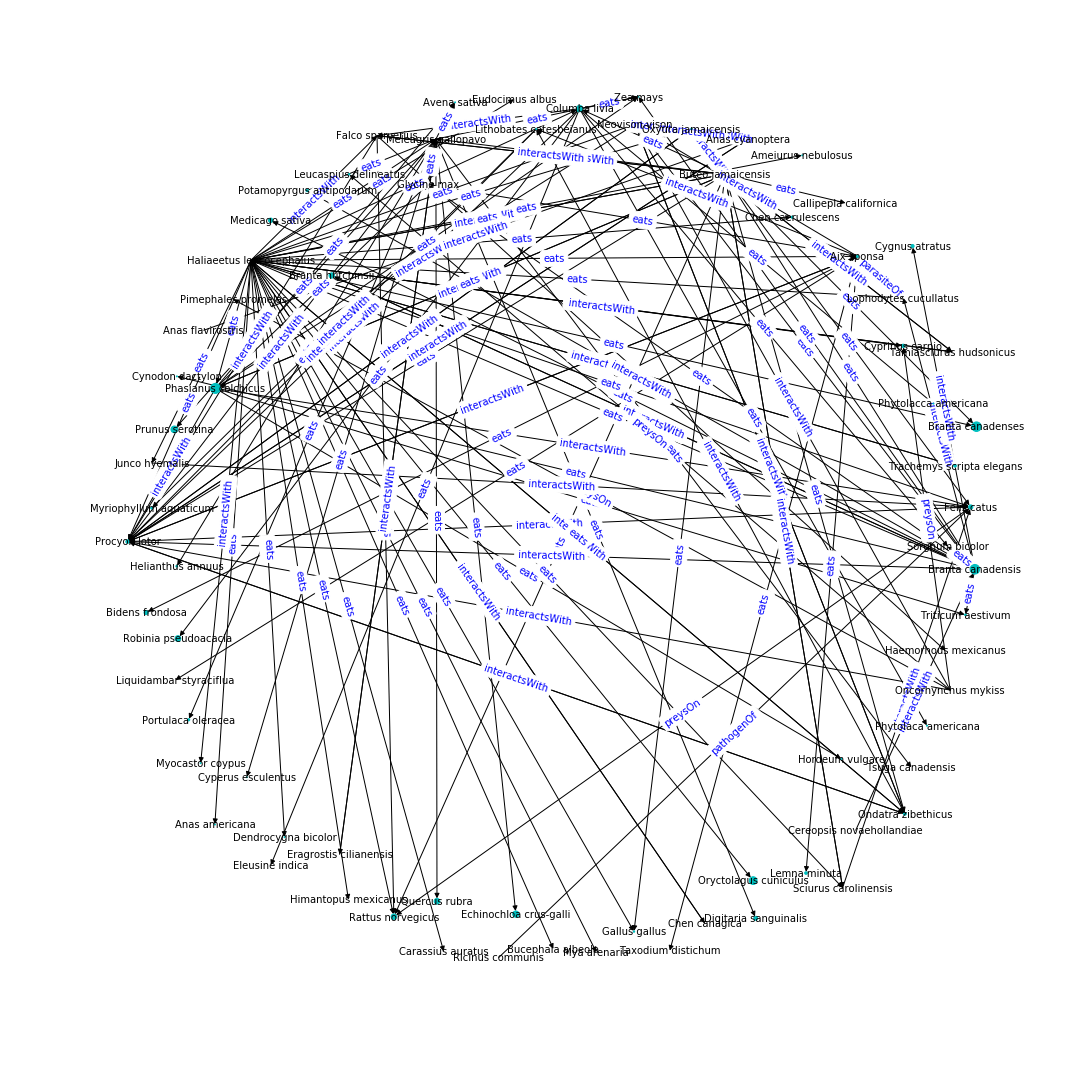

In [107]:
plt.figure(figsize=(15,15))
edge_labels = nx.get_edge_attributes(G,'label')

pos = nx.spring_layout(G, iterations=50, k=50) 
#pos = nx.spring_layout(G)
#pos = nx.random_layout(G)
#pos = nx.circular_layout(G)
#pos = nx.spectral_layout(G)
#pos = nx.shell_layout(G, scale=1)

nodeColors = nx.get_node_attributes(G,'color')

nx.draw_networkx_edge_labels(G,pos, edge_labels = edge_labels, font_size=10, font_color='blue')

#nx.draw_networkx_nodes(G, pos, node_color=nodeColors.values())

nx.draw_networkx(G, pos, with_labels=True, node_size = listOfNodeSizes, node_color='c', alpha= 1, arrows=True, 
                    linewidths=1, font_color="black", font_size=10, style = 'dashed')

plt.axis('off')
plt.tight_layout()
plt.show()

In [108]:
with open(taxon+country+".html", "w") as file:
    file.write(" \
<!DOCTYPE html> \
<html> \
<head> \
<script src='../../../GitHub\cytoscape.js\dist\cytoscape.min.js'></script> \
<script src='https://unpkg.com/layout-base/layout-base.js'></script> \
<script src='https://unpkg.com/cose-base/cose-base.js'></script> \
<script src='../../../GitHub\cytoscape.js-cose-bilkent\cytoscape-cose-bilkent.js'></script> \
</head> \
<style>#cy {width: 90%; height: 90%; position: absolute; top: 50px; left: 150px;}\
body {font-family: 'times; font-size: 6px;}\
</style> \
<body> \
<h1><em font-style: italic;>"+taxon+"</em> in "+country+"</h1>")

### Write out the details of the species

In [109]:
with open(taxon+country+".html", "a") as file:
    file.write("<table><th>Species</th><th>Occupancy</th>")
    

In [110]:
species = G.nodes
with open(taxon+country+".html", "a") as file:
    for n in species:
        file.write("<tr><td><a target='_blank' href=https://www.gbif.org/species/"+str(nx.get_node_attributes(G, 'gbifkey')[n])+">"+n+"</a></td><td>"+str(dictOfNodeSizes[n])+"</td>\n")
        #file.write("<a href=https://www.gbif.org/species/"+str(nx.get_node_attributes(G, 'gbifkey')[n])+">"+n+"</a>, "+str(dictOfNodeSizes[n])+"\n")

In [111]:
with open(taxon+country+".html", "a") as file:
    file.write("</table>")    
file.close()

In [112]:
with open(taxon+country+".html", "a") as file:
    file.write(" \
<div id='cy'></div> \
<script> \
var cy = cytoscape({ \
  container: document.getElementById('cy'), \n \
  elements: [ \
")

### Write nodes to file

In [113]:
file = open(taxon+country+".html", "a")
for n in species:
    file.write("{ data: { id: '"+n+"', href: 'https://www.gbif.org/species/"+str(nx.get_node_attributes(G, 'gbifkey')[n])+"', occnum: "+str(dictOfNodeSizes[n])+" }, },\n")
file.close()

### Write edges to file

In [114]:
file = open(taxon+country+".html", "a")
for edge in G.edges:
    file.write("{data: {id: '"+edge[0]+edge[1]+"', source: '"+edge[0]+"', target: '"+edge[1]+"', label: '"+nx.get_edge_attributes(G, 'label')[edge]+"'}},\n")
file.close()
    

In [115]:
with open(taxon+country+".html", "a") as file:
    file.write("], \
style: [ \n\
        { \n\
            selector: 'node', \n\
            style: { \n\
                shape: 'circle', \n\
                'background-color': 'darkgreen', \n\
                label: 'data(id)', \n\
                'font-family': 'helvetica', \n\
                'font-style': 'italic', \n\
                'font-size': '12px', \n\
                'width': 'mapData(occnum, 0, 400, 3, 150)', \n\
                'height': 'mapData(occnum, 0, 400, 3, 150)' \n\
            } \n\
        },  \n\
        {  \n\
            selector: 'edge',  \n\
            style: {  \n\
                label: 'data(label)', \n\
                'font-family': 'helvetica', \n\
                'font-size': '12px', \n\
                'color': 'blue', \n\
                'curve-style': 'bezier', \n\
                'target-arrow-shape': 'triangle',  \n\
                'width': '1' \n\
                } \n\
            },  \n\
            {  \n\
              selector: ':selected',   \n\
              css: {  \n\
                'line-color': 'red',  \n\
                'background-color': 'red'  \n\
            }  \n\
        }], \n\
layout:  { \n\
            name: 'circle', padding: 10, animate: true, gravity: 30, animationDuration: 1000 \n\
     } \n\
} \n\
); \n\
cy.userZoomingEnabled( true ); \n\
</script> \n\
")

In [116]:
with open(taxon+country+".html", "a") as file:
    file.write("<h2>References</h2><ul>\n")

In [117]:
citations = cleanInteractDataTaxon['sourceCitation'].unique()
file = open(taxon+country+".html", "a")
for ref in citations:
    file.write("<li>"+str(ref)+"</li>\n")
file.close()

In [118]:
with open(taxon+country+".html", "a") as file:
    file.write("</ul> \
        </body> \
        </html>")